# UDACITY Designing Your First Workflow - Step Functions

## Step Functions & SageMaker

In the prior exercises, we've been working with many small services. This can be overwhelming for a data scientist that wants to establish a consistent methodology for handling data. Step Functions is an orchestration service that can allow us to utilize SageMaker in a methodical and consistent way. Step Functions also integrates with Lambda, which can allow us to potentially automate our entire machine learning pipeline end-to-end. Let's get a handle on what a 'step' in a step function looks like.

In this exercise, you will create a preprocessing step and a training step. Then you will create a step function to chain the two steps.

## Exercise: Grant Permissions and install packages.

Attach the IAMFullAccess and the StepFunctionsFullAccess polices to your SageMaker execution role.

In [2]:
%%bash
pip install stepfunctions

## Exercise: Fill out preprocessing step.

The 'step' interface is designed to be quite similar to the Preprocessing Job in lesson 2. The main difference between these is the ability of a 'step' to interface with other steps. Given the successful outcome of a single step, the next step specified in a workflow will automatically continue. In our case, a training step will launch given the successful outcome of a preprocessing step. The preprocessing step has been encoded for you. Upload the preprocessing code 'HelloBlazePreprocess-Toys-N-Games-reviews.py' and the zipped dataset 'Toys_and_Games_5.json.zip' to s3, and fill out the constants in the code below. 

Code below is the preprocessing step. Fill in the constants in the code.

In [3]:
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from stepfunctions.steps.sagemaker import ProcessingStep
import sagemaker

role = get_execution_role()   # Current Sagemaker execution role


PREPROCESSING_JOB_NAME = "my-preprocess-test-job-step-1"

#'S3 LOCATION OF Toys_and_Games_5.json.zip'
input_data = "s3://sagemaker-studio-774397897175-mcs3venir6c/split-sentences-data/unprocessed-data/Toys_and_Games_5.json.zip" 

# 'S3 LOCATION OF HelloBlazePreprocess-Toys-N-Games-reviews.py'
input_preprocessing_code = "s3://sagemaker-studio-774397897175-mcs3venir6c/split-sentences-data/code-file-hello-preprocess/HelloBlazePreprocess-Toys-N-Games-reviews.py"

sess = sagemaker.Session()

# Default session bucket
print(sess.default_bucket())

sagemaker-us-east-1-774397897175


In [4]:
# SKlearn processor
sklearn_processor = SKLearnProcessor(framework_version='0.20.0',  # Sklearn framework version
                                     role=role,
                                     instance_type='ml.m5.large',
                                     instance_count=1)


processed_data_train = "{}{}/{}".format("s3://", sess.default_bucket(), 'toys-n-games-split-sentences-data/processed-data/hello_blaze_train_scikit')
processed_data_test = "{}{}/{}".format("s3://", sess.default_bucket(), 'toys-n-games-split-sentences-data/processed-data/hello_blaze_test_scikit')

inputs=[ProcessingInput(source=input_data, destination='/opt/ml/processing/input', input_name = 'input-1'),  
        ProcessingInput(source=input_preprocessing_code , destination='/opt/ml/processing/input/code', input_name = 'code')]


outputs=[ProcessingOutput(source='/opt/ml/processing/output/train', destination=processed_data_train, output_name = 'train_data'), 
         ProcessingOutput(source='/opt/ml/processing/output/test', destination=processed_data_test, output_name = 'test_data')]


processing_step = ProcessingStep(
    "My SageMaker Pre-processing Step 1",
    processor=sklearn_processor,
    job_name=PREPROCESSING_JOB_NAME,  # "preprocess-test-job-1"
    inputs=inputs,                    # Two inputs: data-path and code path
    outputs=outputs,                  # Two outputs: processed train and test datasets
    container_entrypoint=["python3", "/opt/ml/processing/input/code/HelloBlazePreprocess-Toys-N-Games-reviews.py"],
)

print("\n".join([processed_data_train, processed_data_test]))
print(inputs)

s3://sagemaker-us-east-1-774397897175/toys-n-games-split-sentences-data/processed-data/hello_blaze_train_scikit
s3://sagemaker-us-east-1-774397897175/toys-n-games-split-sentences-data/processed-data/hello_blaze_test_scikit
[<sagemaker.processing.ProcessingInput object at 0x7f23dbedd210>, <sagemaker.processing.ProcessingInput object at 0x7f23dbdd2a50>]


## Exercise: Fill out Training Step

Upon the success of the preprocessing step, we wish to execute a training step. A training step is defined below. Fill the constants in the code.

In [5]:
from stepfunctions.steps.sagemaker import TrainingStep
import boto3

# S3 URI location where the final training outputs manifests
WORKFLOW_OUTPUT = "s3://sagemaker-studio-774397897175-mcs3venir6c/split-sentences-data/training-job-outputs/" 
TRAINING_JOB_NAME = "my-training-job-step-2"

region_name = boto3.Session().region_name      # 'us-east-1' in our case
container = sagemaker.image_uris.retrieve(
    region=region_name, framework="blazingtext", version="1"  # you could also state version explicitly
)

helloBlazeEstimator = sagemaker.estimator.Estimator(
    container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    volume_size=30,
    max_run=360000,
    input_mode="File",                   # File/Pipe. In this case, 'File' mode
    output_path=WORKFLOW_OUTPUT,
    sagemaker_session=sess,
)

helloBlazeEstimator.set_hyperparameters(mode='supervised')   #Set 'Supervised' mode in algorithm hyperparameters

training_step = TrainingStep(
    "My SageMaker Training Step 2",
    estimator=helloBlazeEstimator,
    data={"train": sagemaker.TrainingInput(processed_data_train, content_type="text/plain"), "validation": sagemaker.TrainingInput(processed_data_test, content_type="text/plain")},
    job_name=TRAINING_JOB_NAME,
    wait_for_completion=True,
)

## Exercise: Create Workflow & Execute It. 

To link the steps, you'll need to create a role that is capable of doing so. Go to IAM and create a Step Functions role, and attach the CloudWatchEventsFullAccess and SageMakerFullAccess policies. Once done, make use of the above steps to create a workflow. Quick debugging tip: jobs must have a unique name; you'll need to rename job names when debugging. Consider creating a method that will dynamically create unique job names! 

In [6]:
from stepfunctions.steps import Chain
from stepfunctions.workflow import Workflow

# Step function execution role created with lambda and sagemaker policies and/or permissions granted
workflow_role = "arn:aws:iam::774397897175:role/Step-Functions-Execution-Role-Granted-Permissions"

workflow_graph = Chain([processing_step, training_step])  # Order of executing tasks
workflow = Workflow(
    name="My-Preprocessing-plus-Training-Workflow-Test-1",
    definition=workflow_graph,
    role=workflow_role,
)

# Create a worflow
workflow.create()        

# Start workflow execution
execution = workflow.execute(
    inputs={
        "PreprocessingJobName": PREPROCESSING_JOB_NAME,  # Each pre processing job (SageMaker processing job) requires a unique name,
        "TrainingJobName": TRAINING_JOB_NAME  # Each Sagemaker Training job requires a unique name,       
    }
)

execution_output = execution.get_output(wait=True)

You can track the outcome of this workflow through a custom UI that gets generated! Check it out!

In [7]:
execution.render_progress()

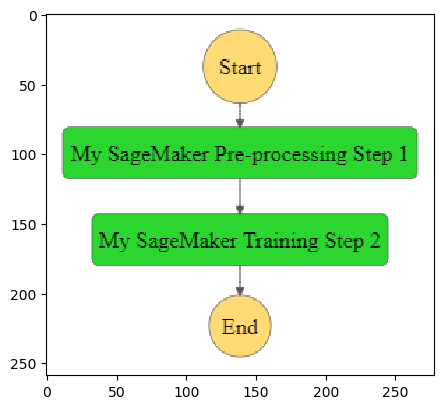

In [24]:
# importing matplotlib modules
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
 
# Read Images
img = mpimg.imread("./stepfunctions_graph_exercise_3.png")
 
# Output Images
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.show()